---
🔽 모델 및 데이터셋 선택

In [1]:
MODEL_NAME = 'patchcore'
DATASET_NAME = 'TR-bearing'



---



# 준비

In [2]:
%%capture
%cd /content/drive/MyDrive/anomaly_detection/ANOMALIB
!pip install -e . -q

In [3]:
import os
from glob import glob
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader
from anomalib.config import get_configurable_parameters
from anomalib.data.inference import InferenceDataset
from anomalib.models import get_model
from anomalib.utils.callbacks import get_callbacks

> 경로 설정

In [4]:
DATA_ROOT = '../datasets/canAIry/'+DATASET_NAME
DATA_INFERENCE = DATA_ROOT+'/inference'
RESULT_ROOT = '../results'
RESULT_INFERENCE = RESULT_ROOT+'/'+MODEL_NAME+'/'+DATASET_NAME+"/images"
WEIGHTS = RESULT_ROOT+'/'+MODEL_NAME+'/'+DATASET_NAME+"/weights"
CONFIG_YAML = 'anomalib/models/'+MODEL_NAME+'/'+DATASET_NAME+'.yaml'
PATH_LABEL = "../../object_detection/datasets/canAIry_raw/"+DATASET_NAME+"/test/labels/"

In [5]:
config = get_configurable_parameters(config_path=CONFIG_YAML)
config.trainer.resume_from_checkpoint = WEIGHTS+'/'+os.listdir(WEIGHTS)[0]
config.visualization.image_save_path = RESULT_INFERENCE

In [6]:
trainer = Trainer(callbacks=get_callbacks(config), **config.trainer)
model = get_model(config)
dataset = InferenceDataset(path=DATA_INFERENCE, image_size=tuple(config.dataset.image_size))
dataloader = DataLoader(dataset)

/content/drive/MyDrive/anomaly_detection/ANOMALIB/anomalib/utils/callbacks/__init__.py:133: UserWarning: Export option: None not found. Defaulting to no model export
  warnings.warn(f"Export option: {config.optimization.export_mode} not found. Defaulting to no model export")
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:52: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  "Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Train

# 추론

In [7]:
predictions = trainer.predict(model=model, dataloaders=[dataloader])

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Predicting: 0it [00:00, ?it/s]

# 결과 분석

In [8]:
correct=0
total=0
for pred in predictions:
  image_path = pred['image_path'][0]
  image_name = image_path.split('/')[-1].split('.')[0][:-4]
  image_id = int(image_path.split('/')[-1].split('.')[0][-2:-1])
  for label in glob(PATH_LABEL+'*.txt'):
    if image_name in label:
      with open(PATH_LABEL+image_name+'.txt', 'r') as r:
        line = r.readlines()
        for i, l in enumerate(line):
          total+=1
          if image_id == i:
            if int(l[0]) == int(not pred["pred_labels"]):
              correct+=1
print(f"{correct}/{total} ({correct/total*100:.2f}%)")

80/120 (66.67%)


## Visualization

In [13]:
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 2.1 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3


In [14]:
from matplotlib import pyplot as plt
from anomalib.post_processing import superimpose_anomaly_map
from anomalib.pre_processing.transforms import Denormalize

TypeError: ignored

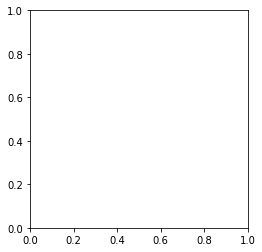

In [39]:
image = predictions[0]["image"]
plt.imshow(image)

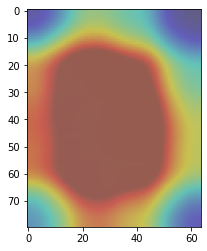

In [15]:
image = predictions[0]["image"]
image = Denormalize()(image)
anomaly_map = predictions[0]["anomaly_maps"]
anomaly_map = anomaly_map.cpu().numpy().squeeze()
heat_map = superimpose_anomaly_map(anomaly_map=anomaly_map, image=image, normalize=True)
plt.imshow(heat_map)